In [1]:
import os
import sys

sys.path.append('/home/jovyan/work/obstacle-detection')
sys.path.append('/home/jovyan/work/')
import numpy as np
import pandas as pd

import pcl
import pcl.pcl_visualization
import pythreejs
import pyntcloud
import matplotlib.pyplot as plt
from importlib import reload  

from pipeline import pcl_pipeline

In [2]:
PATH_TO_DATASET = '/home/jovyan/work/dataset_sampling/rangenet_sampling/dataset/sequences/00/'

In [84]:
scan = np.fromfile(PATH_TO_DATASET + 'velodyne/000005.bin', dtype=np.float32)
scan = scan.reshape((-1, 4))[:, :3]

label = np.fromfile(PATH_TO_DATASET + 'labels/000005.label', dtype=np.uint32)
label = label.reshape((-1))

cloud_XYZ = pcl.PointCloud()
cloud_XYZ.from_array(scan[:,:3])

In [4]:
obstacle_lst = {
  10: "car",
  11: "bicycle",
  13: "bus",
  15: "motorcycle",
  16: "on-rails",
  18: "truck",
  20: "other-vehicle",
  30: "person",
  31: "bicyclist",
  32: "motorcyclist",
  252: "moving-car",
  253: "moving-bicyclist",
  254: "moving-person",
  255: "moving-motorcyclist",
  256: "moving-on-rails",
  257: "moving-bus",
  258: "moving-truck",
  259: "moving-other-vehicle"
}

In [13]:
def roi_filter(pcloud, verbose=True, **params):
    if verbose:
        print('Input pcloud size: {}'.format(len(pcloud)))
    pcloud['camera'] = ((pcloud['x'] > params['min_x']) & (pcloud['x'] < params['max_x']) &
                       (pcloud['y'] >  params['min_y']) & (pcloud['y'] < params['max_y']) &
                       (pcloud['z'] >  params['min_z']) & (pcloud['z'] <  params['max_z']))
    pcloud = pcloud[pcloud['camera'] == True]
    pcloud = pcloud.drop(['camera'], axis=1)
    if verbose:
        print('Output ROI pcloud size: {}'.format(len(pcloud)))
    return pcloud

# pcloud = roi_filter(pcloud, min_x=-6, max_x=50, 
#                   min_y=-20, max_y=25, 
#                   min_z=-2, max_z=2)

In [16]:
pcloud = pd.DataFrame(np.concatenate((scan,label.reshape(len(label), 1)), axis=1), 
                      columns=['x', 'y', 'z', 'seg_id'])
pcloud.seg_id = pcloud.seg_id.astype('uint32')
pcloud.seg_id = pcloud.seg_id.apply(lambda x: x & 0xFFFF)
pcloud = pcloud[pcloud['seg_id'].isin(list(obstacle_lst.keys()))]
pcloud_to_pcl = pcloud.drop(['seg_id'], axis=1)
print(pcloud_to_pcl.shape)
pcloud_pcl = pcl.PointCloud()
pcloud_pcl.from_array(pcloud_to_pcl.to_numpy(dtype=np.float32))

# сколько в метрах?, перебрать параметры по X
pcloud_pcl_roi = pcl_pipeline.roi_filter(pcloud_pcl, [-30, 30], [-6, 8], [-3, 3])

pcloud_pcl_roi_array = np.array(pcloud_pcl_roi, dtype=np.float32)
print(pcloud_pcl_roi_array.shape)

pcloud_pcl_fil = pcloud_pcl_roi.make_statistical_outlier_filter()
pcloud_pcl_fil.set_mean_k(50)
pcloud_pcl_fil.set_std_dev_mul_thresh(1.0)
pcloud_array = np.array(pcloud_pcl_fil.filter(), dtype=np.float32)
print(pcloud_array.shape)

#temp_cloud = pcloud[pcloud.seg_id == 10]
#temp_cloud = temp_cloud.drop(['seg_id'], axis=1)

(16053, 3)
(15408, 3)
(14011, 3)


In [30]:
def plane_segmentation(cloud, dist_thold, max_iter):
    """
    Input parameters:
        cloud: Input cloud
        dist_thold: distance threshold
        max_iter: maximal number of iteration
    Output:
        indices: list of indices of the PCL points that belongs to the plane
        coefficient: the coefficients of the plane-fitting (e.g., [a, b, c, d] for ax + by +cz + d =0)
    """
    seg = cloud.make_segmenter_normals(ksearch=50)# For simplicity,hard coded
    seg.set_optimize_coefficients(True)
    seg.set_model_type(pcl.SACMODEL_NORMAL_PLANE)
    seg.set_method_type(pcl.SAC_RANSAC)
    seg.set_distance_threshold(dist_thold)
    seg.set_max_iterations(max_iter)
    indices, coefficients = seg.segment()
    return indices, coefficients

In [82]:
from datetime import datetime
import time
from importlib import reload  
from pipeline import common

pcl_pipeline = reload(pcl_pipeline)

def pipeline_optimized_pcl(scan, label, obstacle_lst, verbose=False, exec_time=False, **params):

    # get segment id
    start_time = datetime.now()
    pcloud = pd.DataFrame(np.concatenate((scan,label.reshape(len(label), 1)), axis=1), 
                          columns=['x', 'y', 'z', 'seg_id'])

    pcloud = common.obstacle_filter(pcloud, obstacle_lst, proc_labels=True, verbose=False)
    pcloud = pcloud.drop(['seg_id'], axis=1)
    #pcloud = pcloud.drop(['camera'], axis=1)
    obstacle_time = datetime.now() - start_time
    
    start_time = datetime.now()
    pcloud_pcl = pcl.PointCloud()
    pcloud_pcl.from_array(pcloud.to_numpy(dtype=np.float32))
    convert_time = datetime.now() - start_time
    
    # get voxel grid
    start_time = datetime.now()
    #pcloud_pcl = pcl.PointCloud()
    #pcloud_pcl.from_array(pcloud.to_numpy(dtype=np.float32))
    voxelgrid_id = pcl_pipeline.voxel_filter(pcloud_pcl, [params['x_voxels'],
                                                          params['y_voxels'],
                                                          params['z_voxels']])
    #voxelgrid_id = pcloud_pcl  
    voxel_time = datetime.now() - start_time

    # ROI filter
    start_time = datetime.now()
    pcloud_roi = pcl_pipeline.roi_filter(voxelgrid_id, [params['roi_x_min'], params['roi_x_max']], 
                                    [params['roi_y_min'], params['roi_y_max']], 
                                    [params['roi_z_min'], params['roi_z_max']],)
    #pcloud = common.roi_filter(pcloud,  min_x=params['roi_x_min'], max_x=params['roi_x_max'], 
    #                                    min_y=params['roi_y_min'], max_y=params['roi_y_max'],
    #                                    min_z=params['roi_z_min'], max_z=params['roi_z_max'], verbose=False)
    roi_time = datetime.now() - start_time
    
    indices, coefficients = plane_segmentation(pcloud_roi, 0.3, 100)
    print(indices)
    cloud_obsts = pcloud_roi.extract(indices, negative = True)

    # get cluster
    start_time = datetime.now()

    cluster_indices = pcl_pipeline.clustering(cloud_obsts, params['tol_distance'], params['min_cluster_size'], 150000)        
    clustering_time = datetime.now() - start_time
    
    print(np.array(pcloud_pcl, dtype=np.float32).shape, len(cluster_indices))
    
    # get bboxes
    start_time = datetime.now()
    cloud_cluster_list, box_coord_list = pcl_pipeline.get_cluster_box_list(
                                                cluster_indices, cloud_obsts, 
                                                radius_search=params['radius_search'], 
                                                min_neighbors_in_radius=params['min_neighbors_in_radius'])

    bbox_time = datetime.now() - start_time

    n = 1000
    if verbose:
        print('Execution time:')
        print('\n - ROI filtering: {:.0f} ms'.format(roi_time.microseconds / n))
        print('\n - Filtering obstacles: {:.0f} ms'.format(obstacle_time.microseconds / n))
        print('\n - Voxel grid: {:.0f} ms'.format(voxel_time.microseconds / n))
        print('\n - Clustering: {:.0f} ms'.format(clustering_time.microseconds / n))
        print('\n - Min-max cluster points: {:.0f} ms \n'.format(bbox_time.microseconds / n))
        
    if exec_time:
        return box_coord_list, voxelgrid_id, {'roi_time': roi_time.microseconds / n,
                                        'filter_obstacle_time': obstacle_time.microseconds / n,
                                        'voxel_grid_time': voxel_time.microseconds / n,
                                        'clustering_time': clustering_time.microseconds / n,
                                        'outlier_filter_bbox_time': bbox_time.microseconds / n,
                                        'convert_time' : convert_time.microseconds / n}
    else:
        return box_coord_list, voxelgrid_id

In [85]:
params = {'x_voxels'     : 0.3, 'y_voxels': 0.3, 'z_voxels': 0.3, 
          'roi_x_min'    : -30,   'roi_x_max'              : 30,
          'roi_y_min'    : -6, 'roi_y_max'                : 8,
          'roi_z_min'    : -3,  'roi_z_max'                : 3, 
          'tol_distance' : 0.7, 'min_cluster_size'         : 30,
          'radius_search': 0.8,   'min_neighbors_in_radius': 2}
%time box_coord_list, pcloud_pcl, time = pipeline_optimized_pcl(scan, label, obstacle_lst, verbose=True, exec_time=True, **params)

[186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 199, 200, 202, 203, 204, 205, 206, 207, 208, 210, 211, 212, 213, 214, 215, 216, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 269, 270, 271, 272, 274, 275, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 298, 299, 300, 301, 302, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 336, 337, 338, 339, 340, 341, 343, 344, 345, 346, 347, 348, 349, 351, 352, 356, 358]
(6372, 3) 2
Execution time:

 - ROI filtering: 0 ms

 - Filtering obstacles: 438 ms

 - Voxel grid: 3 ms

 - Clustering: 8 ms

 - Min-max cluster points: 2 ms 

CPU times: user 446 ms, sys: 31.2 ms, total: 477 ms
Wall time: 480 ms


In [24]:
box_coord_list, time

([array([[-43.13823318,  45.83708191,  45.83708191, -43.13823318,
          -43.13823318,  45.83708191,  45.83708191, -43.13823318],
         [ -4.20545006,  -4.20545006,   8.9893446 ,   8.9893446 ,
           -4.20545006,  -4.20545006,   8.9893446 ,   8.9893446 ],
         [ -2.04606462,  -2.04606462,  -2.04606462,  -2.04606462,
            0.26768413,   0.26768413,   0.26768413,   0.26768413]]),
  array([[-11.17521   ,  44.60187531,  44.60187531, -11.17521   ,
          -11.17521   ,  44.60187531,  44.60187531, -11.17521   ],
         [ -4.20443678,  -4.20443678,  10.71786785,  10.71786785,
           -4.20443678,  -4.20443678,  10.71786785,  10.71786785],
         [ -1.2731303 ,  -1.2731303 ,  -1.2731303 ,  -1.2731303 ,
            0.26774919,   0.26774919,   0.26774919,   0.26774919]]),
  array([[-43.72450256,  47.29917908,  47.29917908, -43.72450256,
          -43.72450256,  47.29917908,  47.29917908, -43.72450256],
         [ -4.46861839,  -4.46861839,   8.84343815,   8.84343815,

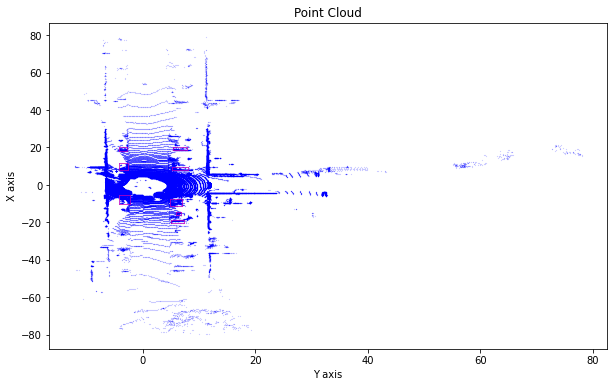

In [35]:
from scripts import draw

%matplotlib inline
f = plt.figure(figsize=(10, 6))
axes = [1,0]
# ax = f.add_subplot(111, projection='3d') 
ax = f.add_subplot(111) 
draw.draw_point_cloud(scan, ax, 'Point Cloud',axes=axes, 
                      axes_str = ['X', 'Y', 'Z'], )
for box in box_coord_list:
     draw.draw_box(ax, box, axes=axes, color='m')

In [132]:
np.array(pcloud_pcl, dtype=np.float32).size

2559

In [22]:
import pandas as pd
scan1 = scan[:,:3]
test_cloud = pyntcloud.PyntCloud(pd.DataFrame(np.array(pcloud_pcl, dtype=np.float32), columns=['x','y','z']))
test_cloud.plot(backend='pythreejs', use_as_color='seg_id')

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(14.612958908081055, 12.31294846534729, -0.52…

In [ ]:
params = {'x_voxels'     : 0.3, 'y_voxels': 0.3, 'z_voxels': 0.3, 
          'roi_x_min'    : -30,   'roi_x_max'              : 30,
          'roi_y_min'    : -6, 'roi_y_max'                : 8,
          'roi_z_min'    : -3,  'roi_z_max'                : 3, 
          'tol_distance' : 0.7, 'min_cluster_size'         : 30,
          'radius_search': 0.8,   'min_neighbors_in_radius': 2}

In [39]:
!pip install sklearn

     |████████████████████████████████| 7.1 MB 593 kB/s eta 0:00:01    |▍                               | 81 kB 213 kB/s eta 0:00:33     |█▌                              | 327 kB 265 kB/s eta 0:00:26     |█████▌                          | 1.2 MB 610 kB/s eta 0:00:10     |████████████                    | 2.6 MB 459 kB/s eta 0:00:10     |█████████████▊                  | 3.0 MB 637 kB/s eta 0:00:07     |████████████████▋               | 3.7 MB 798 kB/s eta 0:00:05     |████████████████████▎           | 4.5 MB 565 kB/s eta 0:00:05     |██████████████████████▉         | 5.0 MB 565 kB/s eta 0:00:04     |████████████████████████▌       | 5.4 MB 435 kB/s eta 0:00:04     |██████████████████████████▏     | 5.8 MB 702 kB/s eta 0:00:02     |██████████████████████████▍     | 5.8 MB 702 kB/s eta 0:00:02     |█████████████████████████████   | 6.4 MB 721 kB/s eta 0:00:01     |██████████████████████████████▉ | 6.8 MB 721 kB/s eta 0:00:01     |███████████████████████████████ | 6.8 MB 721 kB/s eta 0:00

In [42]:
from scripts import test
import sklearn
test = reload(test)
range_params = params = { 'x_voxels'     : [0.3, 0.5, 0.8], 'y_voxels': [0.3, 0.5, 0.8], 'z_voxels': [0.3, 0.5, 0.8], 
                          'roi_x_min'    : [0],   'roi_x_max'                : [45],
                          'roi_y_min'    : [-15], 'roi_y_max'                : [15],
                          'roi_z_min'    : [-2],  'roi_z_max'                : [1], 
                          'tol_distance' : [0.5, 0.7, 0.9], 'min_cluster_size' : [20, 30, 40],
                          'radius_search': [0.5, 0.8, 1],   'min_neighbors_in_radius': [2, 4, 6]}
time_exec_lst = test.grid_search_optimization(scan, label, obstacle_lst, pipeline_optimized_pcl, range_params)

(10679, 3) 5
Total time 494.0350000000001 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 1.014,
   "filter_obstacle_time": 463.999,
   "voxel_grid_time": 6.17,
   "clustering_time": 16.526,
   "outlier_filter_bbox_time": 6.326
}
****************************************

(10679, 3) 8
Total time 538.318 ms. Created 8 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 

(10679, 3) 0
Total time 586.072 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0.497,
   "filter_obstacle_time": 569.913,
   "voxel_grid_time": 7.159,
   "clustering_time": 8.476,
   "outlier_filter_bbox_time": 0.027
}
****************************************

(10679, 3) 2
Total time 750.559 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 0.57,
   "

(10679, 3) 8
Total time 516.971 ms. Created 8 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 0.72,
   "filter_obstacle_time": 494.66,
   "voxel_grid_time": 5.212,
   "clustering_time": 10.796,
   "outlier_filter_bbox_time": 5.583
}
****************************************

(10679, 3) 5
Total time 484.802 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time": 0.669,
   "

(10679, 3) 2
Total time 579.314 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 0.564,
   "filter_obstacle_time": 565.184,
   "voxel_grid_time": 4.101,
   "clustering_time": 7.673,
   "outlier_filter_bbox_time": 1.792
}
****************************************

(10679, 3) 2
Total time 618.071 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 0.394,
   

(10679, 3) 5
Total time 758.8399999999999 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time": 0.845,
   "filter_obstacle_time": 713.891,
   "voxel_grid_time": 12.1,
   "clustering_time": 22.867,
   "outlier_filter_bbox_time": 9.137
}
****************************************

(10679, 3) 6
Total time 555.0360000000001 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "r

(10679, 3) 3
Total time 848.8700000000001 ms. Created 3 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 0.399,
   "filter_obstacle_time": 816.769,
   "voxel_grid_time": 22.964,
   "clustering_time": 6.417,
   "outlier_filter_bbox_time": 2.321
}
****************************************

(10679, 3) 1
Total time 624.5020000000001 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "

(10679, 3) 4
Total time 537.555 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time": 0.822,
   "filter_obstacle_time": 509.359,
   "voxel_grid_time": 5.933,
   "clustering_time": 16.555,
   "outlier_filter_bbox_time": 4.886
}
****************************************

(10679, 3) 4
Total time 634.3580000000001 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time":

(10679, 3) 0
Total time 598.6969999999999 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 0.333,
   "filter_obstacle_time": 586.639,
   "voxel_grid_time": 5.76,
   "clustering_time": 5.934,
   "outlier_filter_bbox_time": 0.031
}
****************************************

(10679, 3) 4
Total time 638.626 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 0

(10679, 3) 5
Total time 611.449 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time": 0.781,
   "filter_obstacle_time": 586.414,
   "voxel_grid_time": 8.264,
   "clustering_time": 11.222,
   "outlier_filter_bbox_time": 4.768
}
****************************************

(10679, 3) 2
Total time 529.6289999999999 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time":

(10679, 3) 4
Total time 632.548 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 0.885,
   "filter_obstacle_time": 568.807,
   "voxel_grid_time": 31.98,
   "clustering_time": 22.216,
   "outlier_filter_bbox_time": 8.66
}
****************************************

(10679, 3) 2
Total time 692.857 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 0.688,
   

(10679, 3) 3
Total time 475.526 ms. Created 3 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0.467,
   "filter_obstacle_time": 460.508,
   "voxel_grid_time": 5.353,
   "clustering_time": 6.569,
   "outlier_filter_bbox_time": 2.629
}
****************************************

(10679, 3) 6
Total time 456.20899999999995 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time":

(10679, 3) 4
Total time 402.938 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 0.499,
   "filter_obstacle_time": 388.941,
   "voxel_grid_time": 5.048,
   "clustering_time": 5.822,
   "outlier_filter_bbox_time": 2.628
}
****************************************

(10679, 3) 2
Total time 432.545 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time": 0.657,
   

(10679, 3) 3
Total time 401.2879999999999 ms. Created 3 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 0.525,
   "filter_obstacle_time": 385.736,
   "voxel_grid_time": 4.751,
   "clustering_time": 8.198,
   "outlier_filter_bbox_time": 2.078
}
****************************************

(10679, 3) 1
Total time 400.17199999999997 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_

(10679, 3) 1
Total time 390.012 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time": 0.459,
   "filter_obstacle_time": 379.515,
   "voxel_grid_time": 4.843,
   "clustering_time": 4.502,
   "outlier_filter_bbox_time": 0.693
}
****************************************

(10679, 3) 1
Total time 461.789 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time": 0.417,
   "fil

(10679, 3) 2
Total time 390.523 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 0.463,
   "filter_obstacle_time": 377.668,
   "voxel_grid_time": 4.795,
   "clustering_time": 6.176,
   "outlier_filter_bbox_time": 1.421
}
****************************************

(10679, 3) 1
Total time 389.79900000000004 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 0.6

(10679, 3) 2
Total time 454.561 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time": 0.549,
   "filter_obstacle_time": 441.6,
   "voxel_grid_time": 5.087,
   "clustering_time": 6.018,
   "outlier_filter_bbox_time": 1.307
}
****************************************

(10679, 3) 0
Total time 437.56100000000004 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time": 0.456

(10679, 3) 2
Total time 442.624 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 0.423,
   "filter_obstacle_time": 430.594,
   "voxel_grid_time": 5.035,
   "clustering_time": 4.789,
   "outlier_filter_bbox_time": 1.783
}
****************************************

(10679, 3) 6
Total time 419.867 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 0.688,
   "fil

(10679, 3) 4
Total time 398.73299999999995 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time": 0.347,
   "filter_obstacle_time": 386.426,
   "voxel_grid_time": 4.87,
   "clustering_time": 4.811,
   "outlier_filter_bbox_time": 2.279
}
****************************************

(10679, 3) 1
Total time 380.019 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0.31

(10679, 3) 5
Total time 393.245 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 0.712,
   "filter_obstacle_time": 372.266,
   "voxel_grid_time": 4.911,
   "clustering_time": 11.586,
   "outlier_filter_bbox_time": 3.77
}
****************************************

(10679, 3) 5
Total time 387.474 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 0.595,
   

(10679, 3) 0
Total time 381.28100000000006 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0.259,
   "filter_obstacle_time": 373.317,
   "voxel_grid_time": 4.624,
   "clustering_time": 3.06,
   "outlier_filter_bbox_time": 0.021
}
****************************************

(10679, 3) 1
Total time 381.509 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 

(10679, 3) 5
Total time 397.64300000000003 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 0.63,
   "filter_obstacle_time": 379.968,
   "voxel_grid_time": 4.911,
   "clustering_time": 8.433,
   "outlier_filter_bbox_time": 3.701
}
****************************************

(10679, 3) 3
Total time 453.01300000000003 ms. Created 3 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "

(10679, 3) 1
Total time 394.988 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 0.457,
   "filter_obstacle_time": 381.806,
   "voxel_grid_time": 7.549,
   "clustering_time": 4.499,
   "outlier_filter_bbox_time": 0.677
}
****************************************

(10679, 3) 0
Total time 381.115 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 0.285,
   

(10679, 3) 4
Total time 388.0 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time": 0.395,
   "filter_obstacle_time": 373.583,
   "voxel_grid_time": 4.674,
   "clustering_time": 6.589,
   "outlier_filter_bbox_time": 2.759
}
****************************************

(10679, 3) 6
Total time 390.169 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time": 0.459,
   "f

(10679, 3) 0
Total time 390.863 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 0.287,
   "filter_obstacle_time": 382.1,
   "voxel_grid_time": 4.794,
   "clustering_time": 3.663,
   "outlier_filter_bbox_time": 0.019
}
****************************************

(10679, 3) 0
Total time 380.73400000000004 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 0

(10679, 3) 2
Total time 426.576 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time": 0.74,
   "filter_obstacle_time": 410.748,
   "voxel_grid_time": 5.275,
   "clustering_time": 8.326,
   "outlier_filter_bbox_time": 1.487
}
****************************************

(10679, 3) 1
Total time 488.136 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time": 0.729,
   "

(10679, 3) 0
Total time 387.48999999999995 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 0.216,
   "filter_obstacle_time": 379.381,
   "voxel_grid_time": 4.787,
   "clustering_time": 3.081,
   "outlier_filter_bbox_time": 0.025
}
****************************************

(10679, 3) 5
Total time 418.33400000000006 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   

(10679, 3) 2
Total time 457.349 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time": 0.506,
   "filter_obstacle_time": 440.94,
   "voxel_grid_time": 8.754,
   "clustering_time": 5.894,
   "outlier_filter_bbox_time": 1.255
}
****************************************

(10679, 3) 0
Total time 502.11 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0.652,
   "f

(10679, 3) 6
Total time 538.0139999999999 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 0.811,
   "filter_obstacle_time": 493.666,
   "voxel_grid_time": 5.373,
   "clustering_time": 32.081,
   "outlier_filter_bbox_time": 6.083
}
****************************************

(10679, 3) 7
Total time 576.722 ms. Created 7 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time":

(10679, 3) 0
Total time 645.8770000000001 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0.504,
   "filter_obstacle_time": 635.695,
   "voxel_grid_time": 5.4,
   "clustering_time": 4.248,
   "outlier_filter_bbox_time": 0.03
}
****************************************

(10679, 3) 3
Total time 411.56199999999995 ms. Created 3 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi

(10679, 3) 8
Total time 534.2420000000001 ms. Created 8 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 0.674,
   "filter_obstacle_time": 500.306,
   "voxel_grid_time": 6.374,
   "clustering_time": 20.669,
   "outlier_filter_bbox_time": 6.219
}
****************************************

(10679, 3) 5
Total time 524.7800000000001 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_

(10679, 3) 2
Total time 393.328 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 0.484,
   "filter_obstacle_time": 376.946,
   "voxel_grid_time": 5.052,
   "clustering_time": 9.655,
   "outlier_filter_bbox_time": 1.191
}
****************************************

(10679, 3) 0
Total time 431.54800000000006 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 0.6

(10679, 3) 5
Total time 499.95700000000005 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time": 0.603,
   "filter_obstacle_time": 480.535,
   "voxel_grid_time": 5.394,
   "clustering_time": 8.57,
   "outlier_filter_bbox_time": 4.855
}
****************************************

(10679, 3) 4
Total time 454.85200000000003 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_

(10679, 3) 2
Total time 390.263 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 0.382,
   "filter_obstacle_time": 378.547,
   "voxel_grid_time": 5.443,
   "clustering_time": 4.741,
   "outlier_filter_bbox_time": 1.15
}
****************************************

(10679, 3) 1
Total time 403.341 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 0.266,
   "filt

(10679, 3) 6
Total time 409.39599999999996 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time": 0.633,
   "filter_obstacle_time": 389.688,
   "voxel_grid_time": 4.81,
   "clustering_time": 9.781,
   "outlier_filter_bbox_time": 4.484
}
****************************************

(10679, 3) 5
Total time 436.11699999999996 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_

(10679, 3) 1
Total time 462.96799999999996 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 0.683,
   "filter_obstacle_time": 449.31,
   "voxel_grid_time": 6.806,
   "clustering_time": 5.171,
   "outlier_filter_bbox_time": 0.998
}
****************************************

(10679, 3) 4
Total time 455.56300000000005 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_

(10679, 3) 4
Total time 405.59100000000007 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time": 0.709,
   "filter_obstacle_time": 387.36,
   "voxel_grid_time": 6.44,
   "clustering_time": 8.583,
   "outlier_filter_bbox_time": 2.499
}
****************************************

(10679, 3) 2
Total time 417.779 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0

(10679, 3) 4
Total time 392.85699999999997 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 0.718,
   "filter_obstacle_time": 376.217,
   "voxel_grid_time": 4.923,
   "clustering_time": 7.635,
   "outlier_filter_bbox_time": 3.364
}
****************************************

(10679, 3) 2
Total time 429.079 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time":

(10679, 3) 2
Total time 394.102 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0.518,
   "filter_obstacle_time": 381.259,
   "voxel_grid_time": 4.729,
   "clustering_time": 6.154,
   "outlier_filter_bbox_time": 1.442
}
****************************************

(10679, 3) 5
Total time 398.68899999999996 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time":

(10679, 3) 2
Total time 484.20099999999996 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 0.486,
   "filter_obstacle_time": 471.214,
   "voxel_grid_time": 4.929,
   "clustering_time": 6.154,
   "outlier_filter_bbox_time": 1.418
}
****************************************

(10679, 3) 2
Total time 493.15599999999995 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   

(10679, 3) 6
Total time 633.677 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 0.558,
   "filter_obstacle_time": 609.986,
   "voxel_grid_time": 4.758,
   "clustering_time": 13.773,
   "outlier_filter_bbox_time": 4.602
}
****************************************

(10679, 3) 4
Total time 44.074 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 0.468,
   

(10679, 3) 2
Total time 473.634 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time": 0.486,
   "filter_obstacle_time": 461.597,
   "voxel_grid_time": 5.427,
   "clustering_time": 4.887,
   "outlier_filter_bbox_time": 1.237
}
****************************************

(10679, 3) 4
Total time 557.762 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time": 0.584,
   

(10679, 3) 1
Total time 452.34 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 0.662,
   "filter_obstacle_time": 437.863,
   "voxel_grid_time": 5.608,
   "clustering_time": 7.322,
   "outlier_filter_bbox_time": 0.885
}
****************************************

(10679, 3) 0
Total time 452.44999999999993 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 

(10679, 3) 1
Total time 391.502 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time": 0.419,
   "filter_obstacle_time": 379.754,
   "voxel_grid_time": 4.855,
   "clustering_time": 5.872,
   "outlier_filter_bbox_time": 0.602
}
****************************************

(10679, 3) 0
Total time 397.82 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time": 0.857,
   "

(10679, 3) 1
Total time 410.287 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 0.423,
   "filter_obstacle_time": 398.071,
   "voxel_grid_time": 4.739,
   "clustering_time": 6.238,
   "outlier_filter_bbox_time": 0.816
}
****************************************

(10679, 3) 5
Total time 414.83099999999996 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time":

(10679, 3) 0
Total time 393.846 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time": 0.451,
   "filter_obstacle_time": 382.765,
   "voxel_grid_time": 5.32,
   "clustering_time": 5.278,
   "outlier_filter_bbox_time": 0.032
}
****************************************

(10679, 3) 0
Total time 391.844 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0.381,
   "

(10679, 3) 6
Total time 431.558 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 0.644,
   "filter_obstacle_time": 408.963,
   "voxel_grid_time": 5.861,
   "clustering_time": 10.659,
   "outlier_filter_bbox_time": 5.431
}
****************************************

(10679, 3) 4
Total time 431.6000000000001 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time":

(10679, 3) 1
Total time 484.594 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0.417,
   "filter_obstacle_time": 472.835,
   "voxel_grid_time": 5.492,
   "clustering_time": 5.059,
   "outlier_filter_bbox_time": 0.791
}
****************************************

(10679, 3) 4
Total time 473.977 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 0.33,
   "

(10679, 3) 5
Total time 512.784 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 0.652,
   "filter_obstacle_time": 486.037,
   "voxel_grid_time": 5.914,
   "clustering_time": 14.458,
   "outlier_filter_bbox_time": 5.723
}
****************************************

(10679, 3) 2
Total time 499.279 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time": 0.748,
   "fi

(10679, 3) 1
Total time 395.35200000000003 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 0.344,
   "filter_obstacle_time": 383.848,
   "voxel_grid_time": 4.806,
   "clustering_time": 5.737,
   "outlier_filter_bbox_time": 0.617
}
****************************************

(10679, 3) 0
Total time 397.98600000000005 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi

(10679, 3) 3
Total time 495.906 ms. Created 3 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time": 0.608,
   "filter_obstacle_time": 457.173,
   "voxel_grid_time": 5.67,
   "clustering_time": 14.707,
   "outlier_filter_bbox_time": 17.748
}
****************************************

(10679, 3) 5
Total time 852.3949999999999 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time": 0.5

(10679, 3) 0
Total time 404.483 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 0.326,
   "filter_obstacle_time": 395.541,
   "voxel_grid_time": 4.965,
   "clustering_time": 3.632,
   "outlier_filter_bbox_time": 0.019
}
****************************************

(10679, 3) 0
Total time 411.66499999999996 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 0.2

(10679, 3) 6
Total time 407.99 ms. Created 6 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time": 0.508,
   "filter_obstacle_time": 390.515,
   "voxel_grid_time": 4.853,
   "clustering_time": 8.035,
   "outlier_filter_bbox_time": 4.079
}
****************************************

(10679, 3) 4
Total time 408.747 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time": 0.43,
   "filte

(10679, 3) 0
Total time 401.612 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 0.283,
   "filter_obstacle_time": 394.119,
   "voxel_grid_time": 4.811,
   "clustering_time": 2.382,
   "outlier_filter_bbox_time": 0.017
}
****************************************

(10679, 3) 4
Total time 462.811 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 0.731,
   "f

(10679, 3) 0
Total time 499.98 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time": 0.463,
   "filter_obstacle_time": 487.18,
   "voxel_grid_time": 5.233,
   "clustering_time": 7.079,
   "outlier_filter_bbox_time": 0.025
}
****************************************

(10679, 3) 0
Total time 462.91999999999996 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0

(10679, 3) 5
Total time 420.74 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 0.824,
   "filter_obstacle_time": 396.89,
   "voxel_grid_time": 5.214,
   "clustering_time": 13.005,
   "outlier_filter_bbox_time": 4.807
}
****************************************

(10679, 3) 4
Total time 450.16999999999996 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 

(10679, 3) 0
Total time 403.515 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0.474,
   "filter_obstacle_time": 389.658,
   "voxel_grid_time": 7.375,
   "clustering_time": 5.981,
   "outlier_filter_bbox_time": 0.027
}
****************************************

(10679, 3) 0
Total time 412.13 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 0.377,
   "

(10679, 3) 5
Total time 496.243 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 1.438,
   "filter_obstacle_time": 466.016,
   "voxel_grid_time": 6.817,
   "clustering_time": 15.193,
   "outlier_filter_bbox_time": 6.779
}
****************************************

(10679, 3) 4
Total time 445.50999999999993 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time"

(10679, 3) 1
Total time 468.61999999999995 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 1.429,
   "filter_obstacle_time": 450.512,
   "voxel_grid_time": 7.87,
   "clustering_time": 7.957,
   "outlier_filter_bbox_time": 0.852
}
****************************************

(10679, 3) 0
Total time 984.419 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 

(10679, 3) 3
Total time 924.249 ms. Created 3 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time": 0.734,
   "filter_obstacle_time": 895.385,
   "voxel_grid_time": 5.608,
   "clustering_time": 17.298,
   "outlier_filter_bbox_time": 5.224
}
****************************************

(10679, 3) 3
Total time 684.7470000000001 ms. Created 3 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time":

(10679, 3) 0
Total time 455.057 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 0.372,
   "filter_obstacle_time": 444.035,
   "voxel_grid_time": 4.822,
   "clustering_time": 5.799,
   "outlier_filter_bbox_time": 0.029
}
****************************************

(10679, 3) 0
Total time 437.944 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 0.334,
   

(10679, 3) 4
Total time 401.404 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time": 0.663,
   "filter_obstacle_time": 381.481,
   "voxel_grid_time": 5.024,
   "clustering_time": 10.751,
   "outlier_filter_bbox_time": 3.485
}
****************************************

(10679, 3) 4
Total time 409.471 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time": 0.596,
  

(10679, 3) 0
Total time 497.333 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 0.339,
   "filter_obstacle_time": 487.908,
   "voxel_grid_time": 4.829,
   "clustering_time": 4.133,
   "outlier_filter_bbox_time": 0.124
}
****************************************

(10679, 3) 3
Total time 479.30100000000004 ms. Created 3 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time":

(10679, 3) 5
Total time 447.853 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time": 0.518,
   "filter_obstacle_time": 428.968,
   "voxel_grid_time": 5.281,
   "clustering_time": 9.124,
   "outlier_filter_bbox_time": 3.962
}
****************************************

(10679, 3) 2
Total time 414.1149999999999 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 

(10679, 3) 4
Total time 425.155 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 0.546,
   "filter_obstacle_time": 407.474,
   "voxel_grid_time": 5.618,
   "clustering_time": 8.455,
   "outlier_filter_bbox_time": 3.062
}
****************************************

(10679, 3) 2
Total time 408.9409999999999 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 

(10679, 3) 1
Total time 429.895 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0.488,
   "filter_obstacle_time": 416.159,
   "voxel_grid_time": 4.913,
   "clustering_time": 7.592,
   "outlier_filter_bbox_time": 0.743
}
****************************************

(10679, 3) 2
Total time 422.772 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 0.628,
   "fil

(10679, 3) 1
Total time 412.449 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 1.242,
   "filter_obstacle_time": 399.627,
   "voxel_grid_time": 5.045,
   "clustering_time": 5.796,
   "outlier_filter_bbox_time": 0.739
}
****************************************

(10679, 3) 0
Total time 403.576 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time": 0.521,
   "fil

(10679, 3) 2
Total time 422.236 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 0.571,
   "filter_obstacle_time": 404.767,
   "voxel_grid_time": 4.976,
   "clustering_time": 9.416,
   "outlier_filter_bbox_time": 2.506
}
****************************************

(10679, 3) 2
Total time 447.18 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 0.579,
   "filt

(10679, 3) 0
Total time 421.327 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time": 0.461,
   "filter_obstacle_time": 410.07,
   "voxel_grid_time": 5.21,
   "clustering_time": 5.567,
   "outlier_filter_bbox_time": 0.019
}
****************************************

(10679, 3) 0
Total time 443.263 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time": 0.462,
   "filte

(10679, 3) 2
Total time 423.588 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 0.516,
   "filter_obstacle_time": 407.874,
   "voxel_grid_time": 5.518,
   "clustering_time": 7.81,
   "outlier_filter_bbox_time": 1.87
}
****************************************

(10679, 3) 1
Total time 444.728 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 0.529,
   "filte

(10679, 3) 1
Total time 411.7970000000001 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time": 0.612,
   "filter_obstacle_time": 399.365,
   "voxel_grid_time": 4.925,
   "clustering_time": 6.23,
   "outlier_filter_bbox_time": 0.665
}
****************************************

(10679, 3) 0
Total time 403.75100000000003 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_t

(10679, 3) 0
Total time 459.94800000000004 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 0.695,
   "filter_obstacle_time": 447.403,
   "voxel_grid_time": 4.985,
   "clustering_time": 6.701,
   "outlier_filter_bbox_time": 0.164
}
****************************************

(10679, 3) 4
Total time 665.68 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 

(10679, 3) 0
Total time 755.637 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time": 0.496,
   "filter_obstacle_time": 744.538,
   "voxel_grid_time": 5.068,
   "clustering_time": 5.512,
   "outlier_filter_bbox_time": 0.023
}
****************************************

(10679, 3) 0
Total time 492.716 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0.317,
   

(10679, 3) 4
Total time 557.141 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 0.64,
   "filter_obstacle_time": 535.568,
   "voxel_grid_time": 5.958,
   "clustering_time": 11.155,
   "outlier_filter_bbox_time": 3.82
}
****************************************

(10679, 3) 5
Total time 607.127 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 1.231,
   "

(10679, 3) 0
Total time 424.876 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0.421,
   "filter_obstacle_time": 415.589,
   "voxel_grid_time": 4.835,
   "clustering_time": 3.91,
   "outlier_filter_bbox_time": 0.121
}
****************************************

(10679, 3) 0
Total time 496.435 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 0.361,
   "

(10679, 3) 4
Total time 455.912 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 0.851,
   "filter_obstacle_time": 431.38,
   "voxel_grid_time": 5.863,
   "clustering_time": 13.296,
   "outlier_filter_bbox_time": 4.522
}
****************************************

(10679, 3) 2
Total time 455.35299999999995 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time":

(10679, 3) 0
Total time 455.893 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 0.585,
   "filter_obstacle_time": 409.987,
   "voxel_grid_time": 33.654,
   "clustering_time": 11.635,
   "outlier_filter_bbox_time": 0.032
}
****************************************

(10679, 3) 0
Total time 445.541 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 0.325,
 

(10679, 3) 1
Total time 638.5 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time": 0.463,
   "filter_obstacle_time": 625.926,
   "voxel_grid_time": 5.169,
   "clustering_time": 5.799,
   "outlier_filter_bbox_time": 1.143
}
****************************************

(10679, 3) 1
Total time 601.6700000000001 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time": 0.

(10679, 3) 0
Total time 490.969 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 0.433,
   "filter_obstacle_time": 481.127,
   "voxel_grid_time": 5.411,
   "clustering_time": 3.971,
   "outlier_filter_bbox_time": 0.027
}
****************************************

(10679, 3) 0
Total time 567.142 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 0.34,
   "

(10679, 3) 3
Total time 586.1600000000001 ms. Created 3 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time": 0.661,
   "filter_obstacle_time": 566.772,
   "voxel_grid_time": 6.283,
   "clustering_time": 9.671,
   "outlier_filter_bbox_time": 2.773
}
****************************************

(10679, 3) 0
Total time 431.214 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time": 

(10679, 3) 0
Total time 464.64400000000006 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 0.302,
   "filter_obstacle_time": 454.981,
   "voxel_grid_time": 5.228,
   "clustering_time": 4.11,
   "outlier_filter_bbox_time": 0.023
}
****************************************

(10679, 3) 5
Total time 429.244 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 

(10679, 3) 1
Total time 437.694 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time": 0.448,
   "filter_obstacle_time": 423.283,
   "voxel_grid_time": 5.629,
   "clustering_time": 7.562,
   "outlier_filter_bbox_time": 0.772
}
****************************************

(10679, 3) 0
Total time 441.921 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0.328,
   

(10679, 3) 4
Total time 494.042 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 0.958,
   "filter_obstacle_time": 469.062,
   "voxel_grid_time": 5.347,
   "clustering_time": 13.78,
   "outlier_filter_bbox_time": 4.895
}
****************************************

(10679, 3) 3
Total time 454.9679999999999 ms. Created 3 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 0.94

(10679, 3) 0
Total time 405.186 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0.353,
   "filter_obstacle_time": 395.724,
   "voxel_grid_time": 4.775,
   "clustering_time": 4.314,
   "outlier_filter_bbox_time": 0.02
}
****************************************

(10679, 3) 0
Total time 425.263 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 0.444,
   "filt

(10679, 3) 4
Total time 418.00699999999995 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 0.679,
   "filter_obstacle_time": 397.906,
   "voxel_grid_time": 5.145,
   "clustering_time": 10.981,
   "outlier_filter_bbox_time": 3.296
}
****************************************

(10679, 3) 4
Total time 424.80500000000006 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "ro

(10679, 3) 0
Total time 399.548 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 0.425,
   "filter_obstacle_time": 387.372,
   "voxel_grid_time": 5.229,
   "clustering_time": 6.504,
   "outlier_filter_bbox_time": 0.018
}
****************************************

(10679, 3) 0
Total time 408.42799999999994 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 0.3

(10679, 3) 4
Total time 402.678 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time": 0.597,
   "filter_obstacle_time": 384.421,
   "voxel_grid_time": 5.437,
   "clustering_time": 8.821,
   "outlier_filter_bbox_time": 3.402
}
****************************************

(10679, 3) 4
Total time 422.12200000000007 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time": 0.6

(10679, 3) 0
Total time 412.74699999999996 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 0.361,
   "filter_obstacle_time": 401.111,
   "voxel_grid_time": 5.405,
   "clustering_time": 5.848,
   "outlier_filter_bbox_time": 0.022
}
****************************************

(10679, 3) 0
Total time 440.25100000000003 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi

(10679, 3) 3
Total time 410.385 ms. Created 3 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time": 0.784,
   "filter_obstacle_time": 390.99,
   "voxel_grid_time": 5.327,
   "clustering_time": 10.799,
   "outlier_filter_bbox_time": 2.485
}
****************************************

(10679, 3) 2
Total time 430.011 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time": 0.504,
   

(10679, 3) 0
Total time 407.21700000000004 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 0.398,
   "filter_obstacle_time": 396.794,
   "voxel_grid_time": 5.867,
   "clustering_time": 4.136,
   "outlier_filter_bbox_time": 0.022
}
****************************************

(10679, 3) 2
Total time 432.115 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time":

(10679, 3) 4
Total time 433.7169999999999 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time": 0.801,
   "filter_obstacle_time": 411.275,
   "voxel_grid_time": 6.113,
   "clustering_time": 11.301,
   "outlier_filter_bbox_time": 4.227
}
****************************************

(10679, 3) 1
Total time 434.984 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time":

(10679, 3) 3
Total time 536.794 ms. Created 3 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 0.705,
   "filter_obstacle_time": 517.093,
   "voxel_grid_time": 5.996,
   "clustering_time": 9.584,
   "outlier_filter_bbox_time": 3.416
}
****************************************

(10679, 3) 1
Total time 656.9839999999999 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 

(10679, 3) 2
Total time 524.205 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0.619,
   "filter_obstacle_time": 509.255,
   "voxel_grid_time": 5.65,
   "clustering_time": 6.956,
   "outlier_filter_bbox_time": 1.725
}
****************************************

(10679, 3) 3
Total time 553.7050000000002 ms. Created 3 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 0

(10679, 3) 2
Total time 415.474 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 0.58,
   "filter_obstacle_time": 400.454,
   "voxel_grid_time": 5.8,
   "clustering_time": 7.168,
   "outlier_filter_bbox_time": 1.472
}
****************************************

(10679, 3) 0
Total time 394.452 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time": 0.383,
   "fi

(10679, 3) 2
Total time 402.824 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 0.593,
   "filter_obstacle_time": 386.948,
   "voxel_grid_time": 5.298,
   "clustering_time": 8.207,
   "outlier_filter_bbox_time": 1.778
}
****************************************

(10679, 3) 1
Total time 440.91200000000003 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time":

(10679, 3) 0
Total time 393.676 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time": 0.419,
   "filter_obstacle_time": 382.989,
   "voxel_grid_time": 5.177,
   "clustering_time": 5.071,
   "outlier_filter_bbox_time": 0.02
}
****************************************

(10679, 3) 0
Total time 409.84000000000003 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time": 

(10679, 3) 2
Total time 402.9270000000001 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 0.504,
   "filter_obstacle_time": 387.795,
   "voxel_grid_time": 5.331,
   "clustering_time": 7.545,
   "outlier_filter_bbox_time": 1.752
}
****************************************

(10679, 3) 0
Total time 399.29999999999995 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "

(10679, 3) 0
Total time 870.833 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time": 0.548,
   "filter_obstacle_time": 855.678,
   "voxel_grid_time": 6.154,
   "clustering_time": 8.417,
   "outlier_filter_bbox_time": 0.036
}
****************************************

(10679, 3) 0
Total time 787.445 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time": 0.392,
   

(10679, 3) 1
Total time 421.344 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 0.418,
   "filter_obstacle_time": 410.45,
   "voxel_grid_time": 4.9,
   "clustering_time": 4.779,
   "outlier_filter_bbox_time": 0.797
}
****************************************

(10679, 3) 4
Total time 412.07300000000004 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 0.

(10679, 3) 0
Total time 414.515 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time": 0.417,
   "filter_obstacle_time": 403.35,
   "voxel_grid_time": 5.397,
   "clustering_time": 5.328,
   "outlier_filter_bbox_time": 0.023
}
****************************************

(10679, 3) 0
Total time 415.65100000000007 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 

(10679, 3) 4
Total time 411.67600000000004 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 0.675,
   "filter_obstacle_time": 392.596,
   "voxel_grid_time": 5.312,
   "clustering_time": 10.021,
   "outlier_filter_bbox_time": 3.072
}
****************************************

(10679, 3) 4
Total time 463.682 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 0.

(10679, 3) 0
Total time 602.9590000000001 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 1.037,
   "filter_obstacle_time": 580.776,
   "voxel_grid_time": 17.964,
   "clustering_time": 3.158,
   "outlier_filter_bbox_time": 0.024
}
****************************************

(10679, 3) 0
Total time 503.39399999999995 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi

(10679, 3) 5
Total time 431.02099999999996 ms. Created 5 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 0.551,
   "filter_obstacle_time": 412.443,
   "voxel_grid_time": 4.885,
   "clustering_time": 9.036,
   "outlier_filter_bbox_time": 4.106
}
****************************************

(10679, 3) 1
Total time 420.149 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time": 0.4

(10679, 3) 0
Total time 412.95799999999997 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 0.341,
   "filter_obstacle_time": 403.292,
   "voxel_grid_time": 4.863,
   "clustering_time": 4.443,
   "outlier_filter_bbox_time": 0.019
}
****************************************

(10679, 3) 0
Total time 416.407 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 0.3

(10679, 3) 2
Total time 498.537 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time": 0.523,
   "filter_obstacle_time": 482.012,
   "voxel_grid_time": 5.188,
   "clustering_time": 9.325,
   "outlier_filter_bbox_time": 1.489
}
****************************************

(10679, 3) 4
Total time 408.45799999999997 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time": 0.7

(10679, 3) 0
Total time 406.877 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 0.319,
   "filter_obstacle_time": 395.477,
   "voxel_grid_time": 7.132,
   "clustering_time": 3.923,
   "outlier_filter_bbox_time": 0.026
}
****************************************

(10679, 3) 0
Total time 379.786 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 0.219,
   "fil

(10679, 3) 1
Total time 436.876 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time": 0.498,
   "filter_obstacle_time": 420.572,
   "voxel_grid_time": 5.515,
   "clustering_time": 9.476,
   "outlier_filter_bbox_time": 0.815
}
****************************************

(10679, 3) 0
Total time 422.987 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time": 0.573,
   

(10679, 3) 0
Total time 376.67800000000005 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 0.483,
   "filter_obstacle_time": 367.207,
   "voxel_grid_time": 5.665,
   "clustering_time": 3.302,
   "outlier_filter_bbox_time": 0.021
}
****************************************

(10679, 3) 4
Total time 417.99 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 

(10679, 3) 0
Total time 440.678 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time": 0.551,
   "filter_obstacle_time": 427.362,
   "voxel_grid_time": 5.486,
   "clustering_time": 7.258,
   "outlier_filter_bbox_time": 0.021
}
****************************************

(10679, 3) 0
Total time 561.663 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0.66,
   "

(10679, 3) 4
Total time 395.371 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 0.86,
   "filter_obstacle_time": 370.955,
   "voxel_grid_time": 5.404,
   "clustering_time": 13.836,
   "outlier_filter_bbox_time": 4.316
}
****************************************

(10679, 3) 4
Total time 394.56299999999993 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time":

(10679, 3) 0
Total time 385.95200000000006 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0.345,
   "filter_obstacle_time": 376.138,
   "voxel_grid_time": 5.021,
   "clustering_time": 4.425,
   "outlier_filter_bbox_time": 0.023
}
****************************************

(10679, 3) 0
Total time 392.48099999999994 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   

(10679, 3) 1
Total time 388.17800000000005 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 0.829,
   "filter_obstacle_time": 370.204,
   "voxel_grid_time": 6.033,
   "clustering_time": 10.312,
   "outlier_filter_bbox_time": 0.8
}
****************************************

(10679, 3) 2
Total time 390.42299999999994 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "

(10679, 3) 0
Total time 398.032 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 0.681,
   "filter_obstacle_time": 382.762,
   "voxel_grid_time": 5.908,
   "clustering_time": 8.654,
   "outlier_filter_bbox_time": 0.027
}
****************************************

(10679, 3) 0
Total time 416.137 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 0.405,
   

(10679, 3) 2
Total time 459.48600000000005 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time": 0.589,
   "filter_obstacle_time": 437.346,
   "voxel_grid_time": 5.079,
   "clustering_time": 12.99,
   "outlier_filter_bbox_time": 3.482
}
****************************************

(10679, 3) 3
Total time 388.029 ms. Created 3 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time":

(10679, 3) 0
Total time 423.73499999999996 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 0.428,
   "filter_obstacle_time": 410.058,
   "voxel_grid_time": 5.39,
   "clustering_time": 7.835,
   "outlier_filter_bbox_time": 0.024
}
****************************************

(10679, 3) 0
Total time 383.405 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 

(10679, 3) 4
Total time 415.8880000000001 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time": 0.677,
   "filter_obstacle_time": 394.675,
   "voxel_grid_time": 6.095,
   "clustering_time": 10.956,
   "outlier_filter_bbox_time": 3.485
}
****************************************

(10679, 3) 2
Total time 405.363 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time":

(10679, 3) 0
Total time 388.234 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 0.433,
   "filter_obstacle_time": 379.387,
   "voxel_grid_time": 4.75,
   "clustering_time": 3.637,
   "outlier_filter_bbox_time": 0.027
}
****************************************

(10679, 3) 3
Total time 393.774 ms. Created 3 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 0.904,
   "

(10679, 3) 0
Total time 387.185 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time": 0.604,
   "filter_obstacle_time": 372.703,
   "voxel_grid_time": 5.379,
   "clustering_time": 8.48,
   "outlier_filter_bbox_time": 0.019
}
****************************************

(10679, 3) 0
Total time 920.0650000000002 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0.465

(10679, 3) 1
Total time 425.83 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 0.747,
   "filter_obstacle_time": 405.567,
   "voxel_grid_time": 5.816,
   "clustering_time": 12.844,
   "outlier_filter_bbox_time": 0.856
}
****************************************

(10679, 3) 0
Total time 447.95300000000003 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 0.4

(10679, 3) 1
Total time 407.55999999999995 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0.499,
   "filter_obstacle_time": 392.376,
   "voxel_grid_time": 5.503,
   "clustering_time": 8.126,
   "outlier_filter_bbox_time": 1.056
}
****************************************

(10679, 3) 2
Total time 419.423 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 0.6

(10679, 3) 0
Total time 412.4320000000001 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 0.612,
   "filter_obstacle_time": 398.136,
   "voxel_grid_time": 5.79,
   "clustering_time": 7.874,
   "outlier_filter_bbox_time": 0.02
}
****************************************

(10679, 3) 0
Total time 400.71999999999997 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_ti

(10679, 3) 3
Total time 416.877 ms. Created 3 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 0.741,
   "filter_obstacle_time": 397.887,
   "voxel_grid_time": 6.522,
   "clustering_time": 9.18,
   "outlier_filter_bbox_time": 2.547
}
****************************************

(10679, 3) 1
Total time 411.6889999999999 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 0.594

(10679, 3) 0
Total time 431.33599999999996 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time": 0.411,
   "filter_obstacle_time": 418.803,
   "voxel_grid_time": 7.082,
   "clustering_time": 5.013,
   "outlier_filter_bbox_time": 0.027
}
****************************************

(10679, 3) 0
Total time 405.43899999999996 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi

(10679, 3) 0
Total time 411.70799999999997 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 0.468,
   "filter_obstacle_time": 399.125,
   "voxel_grid_time": 5.097,
   "clustering_time": 7.0,
   "outlier_filter_bbox_time": 0.018
}
****************************************

(10679, 3) 0
Total time 391.51 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 0.

(10679, 3) 0
Total time 438.30699999999996 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time": 0.542,
   "filter_obstacle_time": 424.567,
   "voxel_grid_time": 5.907,
   "clustering_time": 7.26,
   "outlier_filter_bbox_time": 0.031
}
****************************************

(10679, 3) 0
Total time 421.084 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time": 

(10679, 3) 0
Total time 399.571 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 0.487,
   "filter_obstacle_time": 387.695,
   "voxel_grid_time": 5.108,
   "clustering_time": 6.259,
   "outlier_filter_bbox_time": 0.022
}
****************************************

(10679, 3) 4
Total time 413.619 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 1.24,
   "

(10679, 3) 0
Total time 400.468 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time": 0.475,
   "filter_obstacle_time": 387.402,
   "voxel_grid_time": 5.731,
   "clustering_time": 6.839,
   "outlier_filter_bbox_time": 0.021
}
****************************************

(10679, 3) 0
Total time 382.247 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0.409,
   

(10679, 3) 4
Total time 401.417 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 0.667,
   "filter_obstacle_time": 376.859,
   "voxel_grid_time": 5.981,
   "clustering_time": 13.375,
   "outlier_filter_bbox_time": 4.535
}
****************************************

(10679, 3) 4
Total time 394.973 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 0.571,
  

(10679, 3) 0
Total time 382.579 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0.093,
   "filter_obstacle_time": 373.806,
   "voxel_grid_time": 4.17,
   "clustering_time": 4.484,
   "outlier_filter_bbox_time": 0.026
}
****************************************

(10679, 3) 0
Total time 401.67499999999995 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 

(10679, 3) 0
Total time 472.34000000000003 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 0.608,
   "filter_obstacle_time": 453.945,
   "voxel_grid_time": 5.487,
   "clustering_time": 12.279,
   "outlier_filter_bbox_time": 0.021
}
****************************************

(10679, 3) 1
Total time 445.19300000000004 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
  

(10679, 3) 0
Total time 387.23199999999997 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 0.344,
   "filter_obstacle_time": 376.988,
   "voxel_grid_time": 4.864,
   "clustering_time": 5.007,
   "outlier_filter_bbox_time": 0.029
}
****************************************

(10679, 3) 0
Total time 381.654 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time":

(10679, 3) 1
Total time 419.11199999999997 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time": 0.428,
   "filter_obstacle_time": 404.926,
   "voxel_grid_time": 5.118,
   "clustering_time": 7.425,
   "outlier_filter_bbox_time": 1.215
}
****************************************

(10679, 3) 1
Total time 408.21899999999994 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   

(10679, 3) 0
Total time 440.653 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 0.472,
   "filter_obstacle_time": 428.781,
   "voxel_grid_time": 6.588,
   "clustering_time": 4.786,
   "outlier_filter_bbox_time": 0.026
}
****************************************

(10679, 3) 0
Total time 452.044 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 0.279,
   

(10679, 3) 2
Total time 415.598 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time": 0.473,
   "filter_obstacle_time": 400.031,
   "voxel_grid_time": 5.459,
   "clustering_time": 7.796,
   "outlier_filter_bbox_time": 1.839
}
****************************************

(10679, 3) 1
Total time 411.25100000000003 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time":

(10679, 3) 0
Total time 399.76 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 0.221,
   "filter_obstacle_time": 391.337,
   "voxel_grid_time": 5.084,
   "clustering_time": 3.091,
   "outlier_filter_bbox_time": 0.027
}
****************************************

(10679, 3) 3
Total time 438.59799999999996 ms. Created 3 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 2.

(10679, 3) 0
Total time 401.148 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time": 0.492,
   "filter_obstacle_time": 388.586,
   "voxel_grid_time": 5.007,
   "clustering_time": 6.932,
   "outlier_filter_bbox_time": 0.131
}
****************************************

(10679, 3) 0
Total time 413.56699999999995 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0.4

(10679, 3) 4
Total time 462.188 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 1.794,
   "filter_obstacle_time": 430.033,
   "voxel_grid_time": 8.032,
   "clustering_time": 17.478,
   "outlier_filter_bbox_time": 4.851
}
****************************************

(10679, 3) 2
Total time 610.2590000000001 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 1.5

(10679, 3) 0
Total time 780.164 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0.789,
   "filter_obstacle_time": 767.179,
   "voxel_grid_time": 8.048,
   "clustering_time": 4.131,
   "outlier_filter_bbox_time": 0.017
}
****************************************

(10679, 3) 0
Total time 865.9170000000001 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 0.57

(10679, 3) 4
Total time 816.192 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 0.71,
   "filter_obstacle_time": 785.729,
   "voxel_grid_time": 10.958,
   "clustering_time": 13.506,
   "outlier_filter_bbox_time": 5.289
}
****************************************

(10679, 3) 2
Total time 516.99 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time": 0.544,
   "fil

(10679, 3) 0
Total time 466.87499999999994 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 0.46,
   "filter_obstacle_time": 455.026,
   "voxel_grid_time": 4.871,
   "clustering_time": 6.498,
   "outlier_filter_bbox_time": 0.02
}
****************************************

(10679, 3) 0
Total time 397.75800000000004 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_t

(10679, 3) 2
Total time 393.628 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time": 0.537,
   "filter_obstacle_time": 378.896,
   "voxel_grid_time": 4.776,
   "clustering_time": 7.777,
   "outlier_filter_bbox_time": 1.642
}
****************************************

(10679, 3) 2
Total time 434.578 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time": 0.727,
   

(10679, 3) 0
Total time 447.308 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 0.323,
   "filter_obstacle_time": 436.331,
   "voxel_grid_time": 6.111,
   "clustering_time": 4.526,
   "outlier_filter_bbox_time": 0.017
}
****************************************

(10679, 3) 0
Total time 798.2139999999999 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 

(10679, 3) 3
Total time 428.32599999999996 ms. Created 3 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time": 0.703,
   "filter_obstacle_time": 410.473,
   "voxel_grid_time": 4.972,
   "clustering_time": 9.468,
   "outlier_filter_bbox_time": 2.71
}
****************************************

(10679, 3) 1
Total time 437.605 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time": 

(10679, 3) 0
Total time 375.68399999999997 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 0.328,
   "filter_obstacle_time": 367.313,
   "voxel_grid_time": 4.611,
   "clustering_time": 3.413,
   "outlier_filter_bbox_time": 0.019
}
****************************************

(10679, 3) 1
Total time 400.891 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time":

(10679, 3) 2
Total time 404.431 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time": 0.54,
   "filter_obstacle_time": 387.356,
   "voxel_grid_time": 4.656,
   "clustering_time": 9.888,
   "outlier_filter_bbox_time": 1.991
}
****************************************

(10679, 3) 2
Total time 384.39599999999996 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 

(10679, 3) 3
Total time 385.473 ms. Created 3 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 0.55,
   "filter_obstacle_time": 370.038,
   "voxel_grid_time": 4.698,
   "clustering_time": 7.788,
   "outlier_filter_bbox_time": 2.399
}
****************************************

(10679, 3) 0
Total time 400.291 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 0.546,
   "

(10679, 3) 0
Total time 389.0280000000001 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0.415,
   "filter_obstacle_time": 377.785,
   "voxel_grid_time": 4.802,
   "clustering_time": 6.007,
   "outlier_filter_bbox_time": 0.019
}
****************************************

(10679, 3) 1
Total time 420.77000000000004 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "

(10679, 3) 0
Total time 393.316 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 0.423,
   "filter_obstacle_time": 381.006,
   "voxel_grid_time": 5.694,
   "clustering_time": 6.175,
   "outlier_filter_bbox_time": 0.018
}
****************************************

(10679, 3) 0
Total time 382.24899999999997 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time":

(10679, 3) 2
Total time 443.757 ms. Created 2 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 0.714,
   "filter_obstacle_time": 425.736,
   "voxel_grid_time": 5.32,
   "clustering_time": 9.966,
   "outlier_filter_bbox_time": 2.021
}
****************************************

(10679, 3) 0
Total time 448.297 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 0.43,
   "f

(10679, 3) 0
Total time 395.49799999999993 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_time": 0.631,
   "filter_obstacle_time": 384.194,
   "voxel_grid_time": 5.294,
   "clustering_time": 5.361,
   "outlier_filter_bbox_time": 0.018
}
****************************************

(10679, 3) 0
Total time 407.772 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time":

(10679, 3) 1
Total time 384.60699999999997 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 0.493,
   "filter_obstacle_time": 370.638,
   "voxel_grid_time": 4.829,
   "clustering_time": 7.766,
   "outlier_filter_bbox_time": 0.881
}
****************************************

(10679, 3) 0
Total time 407.004 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time":

(10679, 3) 0
Total time 385.755 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.3
}
{
   "roi_time": 0.432,
   "filter_obstacle_time": 374.036,
   "voxel_grid_time": 4.815,
   "clustering_time": 6.452,
   "outlier_filter_bbox_time": 0.02
}
****************************************

(10679, 3) 0
Total time 403.024 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time": 0.494,
   "

(10679, 3) 0
Total time 457.315 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.8
}
{
   "roi_time": 0.372,
   "filter_obstacle_time": 446.049,
   "voxel_grid_time": 5.14,
   "clustering_time": 5.73,
   "outlier_filter_bbox_time": 0.024
}
****************************************

(10679, 3) 1
Total time 457.717 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 0.831,
   "filte

(10679, 3) 0
Total time 416.12699999999995 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.5
}
{
   "roi_time": 0.342,
   "filter_obstacle_time": 406.039,
   "voxel_grid_time": 4.812,
   "clustering_time": 4.912,
   "outlier_filter_bbox_time": 0.022
}
****************************************

(10679, 3) 0
Total time 402.985 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0.3

(10679, 3) 4
Total time 470.12200000000007 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.3
}
{
   "roi_time": 0.833,
   "filter_obstacle_time": 446.855,
   "voxel_grid_time": 6.17,
   "clustering_time": 12.772,
   "outlier_filter_bbox_time": 3.492
}
****************************************

(10679, 3) 4
Total time 465.07000000000005 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi

(10679, 3) 0
Total time 452.42 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.8
}
{
   "roi_time": 0.43,
   "filter_obstacle_time": 442.415,
   "voxel_grid_time": 5.212,
   "clustering_time": 4.341,
   "outlier_filter_bbox_time": 0.022
}
****************************************

(10679, 3) 0
Total time 432.38100000000003 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 0.45,

(10679, 3) 4
Total time 477.13700000000006 ms. Created 4 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.5
}
{
   "roi_time": 0.586,
   "filter_obstacle_time": 457.149,
   "voxel_grid_time": 5.069,
   "clustering_time": 9.577,
   "outlier_filter_bbox_time": 4.756
}
****************************************

(10679, 3) 1
Total time 821.5889999999999 ms. Created 1 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.8
}
{
   "roi_

(10679, 3) 0
Total time 517.652 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.3
}
{
   "roi_time": 0.13,
   "filter_obstacle_time": 502.813,
   "voxel_grid_time": 7.786,
   "clustering_time": 6.901,
   "outlier_filter_bbox_time": 0.022
}
****************************************

(10679, 3) 0
Total time 427.68500000000006 ms. Created 0 clusters
****************************************
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.5
}
{
   "roi_time": 0.44

In [71]:
sorted_exec_dct = {k: v for k, v in sorted(time_exec_lst.items(), key=lambda item: item[1][0])}

In [72]:
for key in sorted_exec_dct:
    print(key,'Time and n clusters', sorted_exec_dct[key])

{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.8
} Time and n clusters (36.754, 1)
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.5
} Time and n clusters (44.074, 4)
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.3
} Time and n clusters (44.367, 4)
{
   "min_cluster_size": 20,
  

} Time and n clusters (396.01000000000005, 0)
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.3
} Time and n clusters (396.03499999999997, 4)
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.8
} Time and n clusters (396.06699999999995, 2)
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.8

} Time and n clusters (397.58, 3)
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.5
} Time and n clusters (397.596, 0)
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.5
} Time and n clusters (397.64300000000003, 5)
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.8
} Time and n clusters 

{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.8
} Time and n clusters (402.44199999999995, 2)
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.3
} Time and n clusters (402.478, 5)
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.3
} Time and n clusters (402.51599999999996, 2)
{
   "min_cl

} Time and n clusters (408.143, 5)
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.8
} Time and n clusters (408.157, 0)
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.5
} Time and n clusters (408.16099999999994, 5)
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.8
} Time and n clusters (

{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.5
} Time and n clusters (414.30100000000004, 1)
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.5
} Time and n clusters (414.44000000000005, 0)
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.3
} Time and n clusters (414.449, 1)
{
   "min_

} Time and n clusters (420.563, 2)
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.5
} Time and n clusters (420.589, 0)
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.8
} Time and n clusters (420.682, 0)
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.8,
   "z_voxels": 0.8
} Time and n clusters (420.69,

{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.3
} Time and n clusters (430.40900000000005, 3)
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.3
} Time and n clusters (430.49899999999997, 4)
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.5
} Time and n clusters (430.50699999999995, 

} Time and n clusters (443.936, 0)
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.8
} Time and n clusters (444.01400000000007, 0)
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.3
} Time and n clusters (444.339, 2)
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.3
} Time and n clusters

{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.5,
   "z_voxels": 0.5
} Time and n clusters (459.4440000000001, 0)
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.8
} Time and n clusters (459.477, 0)
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.8
} Time and n clusters (459.48600000000005, 2)
{
   "min_c

} Time and n clusters (480.087, 5)
{
   "min_cluster_size": 40,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.3
} Time and n clusters (480.115, 1)
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.5,
   "y_voxels": 0.5,
   "z_voxels": 0.8
} Time and n clusters (480.37699999999995, 0)
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.5
} Time and n clus

} Time and n clusters (553.4710000000001, 2)
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.8,
   "y_voxels": 0.3,
   "z_voxels": 0.5
} Time and n clusters (553.5500000000002, 1)
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.5,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.8,
   "z_voxels": 0.3
} Time and n clusters (553.7050000000002, 3)
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 4,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.7,
   "x_voxels": 0.3,
   "y_voxels": 0.5,
   "z_voxels": 0.

} Time and n clusters (646.658, 1)
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 6,
   "radius_search": 1,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.8,
   "z_voxels": 0.8
} Time and n clusters (651.373, 0)
{
   "min_cluster_size": 30,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.5
} Time and n clusters (652.183, 4)
{
   "min_cluster_size": 20,
   "min_neighbors_in_radius": 2,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.5,
   "x_voxels": 0.5,
   "y_voxels": 0.3,
   "z_voxels": 0.5
} Time and n clusters (652.647

In [44]:
import glob
scan_lst = sorted(glob.glob(PATH_TO_DATASET + "velodyne/*.bin"))
labels_lst = sorted(glob.glob(PATH_TO_DATASET + "labels/*.label"))
assert len(scan_lst) == len(labels_lst)
print('READ OK, number of scans ', len(scan_lst))

READ OK, number of scans  459


In [43]:
PATH_TO_DATASET

'/home/jovyan/work/dataset_sampling/rangenet_sampling/dataset/sequences/00/'

In [ ]:
"min_cluster_size": 20,
   "min_neighbors_in_radius": 6,
   "radius_search": 0.8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 15,
   "roi_y_min": -15,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "tol_distance": 0.9,
   "x_voxels": 0.3,
   "y_voxels": 0.3,
   "z_voxels": 0.3

In [73]:
params_ = {'x_voxels'     : 0.3, 'y_voxels': 0.3, 'z_voxels': 0.3, 
          'roi_x_min'    : 0,   'roi_x_max'              : 45,
          'roi_y_min'    : -15, 'roi_y_max'                : 15,
          'roi_z_min'    : -2,  'roi_z_max'                : 1, 
          'tol_distance' : 0.9, 'min_cluster_size'         : 20,
          'radius_search': 0.8,   'min_neighbors_in_radius': 6}

In [74]:
%%time
n_scan = -1
write_path = PATH_TO_DATASET + 'clusters/'
# write_path = None
bbox_dct, exec_time_dct, stats = test.get_bbox_and_stat(scan_lst[:n_scan], labels_lst[:n_scan], obstacle_lst,
                                                 pipeline_optimized_pcl, 
                                                 write_path=write_path, detailed=True, **params_)

(4322, 3) 4
(4460, 3) 5
(4797, 3) 3
(5133, 3) 4
(5582, 3) 4
(6372, 3) 5
(6948, 3) 4
(7631, 3) 4
(7690, 3) 6
(7488, 3) 4
(8363, 3) 4
(9398, 3) 3
(9306, 3) 4
(8938, 3) 3
(9060, 3) 3
(8409, 3) 4
(7636, 3) 3
(7470, 3) 5
(7116, 3) 5
(6631, 3) 4
(6171, 3) 4
(5953, 3) 4
(5966, 3) 4
(6059, 3) 4
(6109, 3) 5
(6394, 3) 4
(6817, 3) 4
(7291, 3) 4
(7780, 3) 6
(8415, 3) 4
(8972, 3) 5
(9230, 3) 5
(9478, 3) 5
(9860, 3) 6
(9884, 3) 7
(9761, 3) 5
(9888, 3) 6
(10007, 3) 6
(10059, 3) 6
(10497, 3) 7
(11157, 3) 6
(12610, 3) 6
(14852, 3) 6
(16918, 3) 6
(18228, 3) 7
(20301, 3) 5
(21941, 3) 6
(21363, 3) 6
(20706, 3) 5
(18890, 3) 5
(16052, 3) 4
(13436, 3) 5
(11743, 3) 6
(10758, 3) 6
(10378, 3) 7
(10679, 3) 6
(11345, 3) 7
(11460, 3) 8
(11651, 3) 8
(12219, 3) 8
(14471, 3) 8
(16379, 3) 8
(16667, 3) 8
(17074, 3) 7
(18397, 3) 8
(18403, 3) 6
(18022, 3) 6
(17911, 3) 6
(17147, 3) 5
(16596, 3) 5
(16053, 3) 5
(16049, 3) 6
(16750, 3) 5
(17680, 3) 6
(18195, 3) 6
(19133, 3) 7
(20674, 3) 8
(20868, 3) 8
(20379, 3) 8
(20411, 3)

In [75]:
steps = list(stats[0].keys())
steps_exec_time = []
for step in steps:
    steps_exec_time.append([stat[step] for stat in stats])

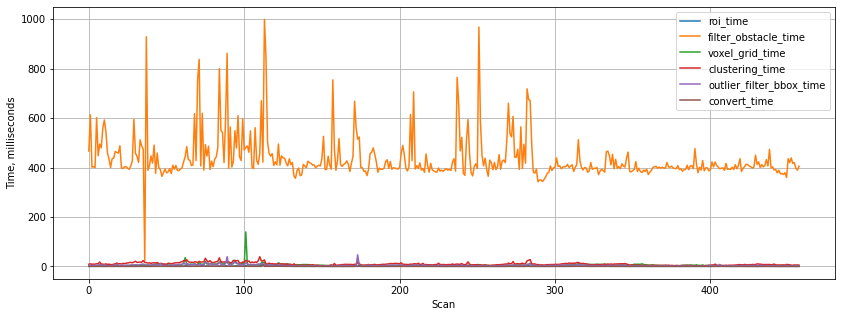

In [76]:
plt.figure(figsize=(14,5))
for i, step in enumerate(steps):
    plt.plot(steps_exec_time[i], label=step)
plt.legend(loc='best')
plt.xlabel('Scan')
plt.ylabel('Time, milliseconds')
plt.grid()
plt.show()

In [77]:
time_stat = list(exec_time_dct.values())
print('Min process time {} ms'.format(min(time_stat)))
print('Mean process time {} ms'.format(np.mean(time_stat)))
print('Max process time {} ms'.format(max(time_stat)))

Min process time 3.115 ms
Mean process time 478.2293187772926 ms
Max process time 947.537 ms


In [78]:
ox = [int(x) for x in list(exec_time_dct.keys())]
oy = time_stat

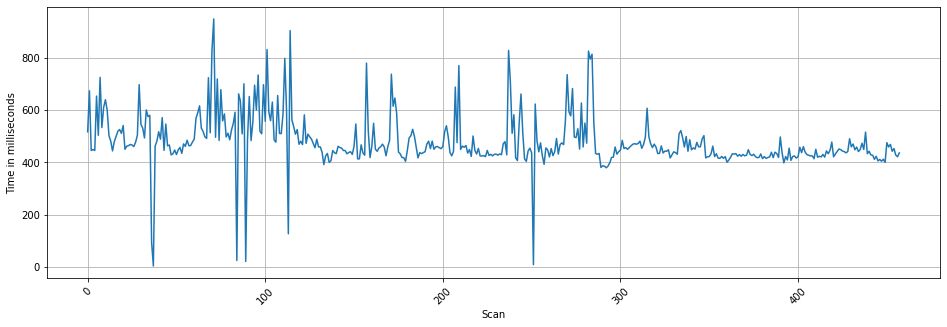

In [79]:
plt.figure(figsize=(16, 5))
plt.plot(ox, oy)
plt.xlabel('Scan')
plt.ylabel('Time in milliseconds')
plt.grid()
plt.xticks(rotation=45)
plt.show()